In [1]:
%cd ../src

/home/edvard/Workspace/tgraphnet/src


In [2]:
%ls

angles/      features/  simple_animation_central.gif  temprola_mpjple.png
common/      graph/     simple_animation.gif          vizualization/
data/        loss/      simple_animation_global.gif
evaluation/  models/    simple_animation_glob.gif


In [3]:
import os
from common.utils import Params, set_logger, copy_weight, load_checkpoint, save_checkpoint_pos_ori, write_log, get_lr, write_train_summary_scalars, write_val_summary_joint, change_momentum
from features.networks import TGraphNet, TGraphNetSeq
from vizualization.vizualize import plot_adjacency_matrix, plot_pose_animation, plot_poses_only
from common.h36m_skeleton import get_node_names, get_edge_names
import torch
from graph import Graph
import numpy as np

from data.h36m_dataset import Human36M
from data.pw3d_dataset import PW3D
from common.h36m_skeleton import joint_id_to_names
from data.generators import ChunkedGenerator_Seq, UnchunkedGenerator_Seq, ChunkedGenerator_Frame, ChunkedGenerator_Seq2Seq, eval_data_prepare

/home/edvard/Workspace/env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load parameters
json_path = os.path.join('../models/stgcn/run14/params.json')
assert os.path.isfile(json_path), "No json file found at {}".format(json_path)
params = Params(json_path)

In [5]:
checkpoint = torch.load('../models/stgcn/run14/best_pos.pth.tar')

In [6]:
checkpoint['state_dict'].keys()

odict_keys(['adj_v', 'adj_e', 'downsample_layers.0.adj_v', 'downsample_layers.0.adj_e', 'downsample_layers.0.graph_stages.0.gcn.weight', 'downsample_layers.0.graph_stages.0.gcn.bias', 'downsample_layers.0.graph_stages.0.gcn.norm.weight', 'downsample_layers.0.graph_stages.0.gcn.norm.bias', 'downsample_layers.0.graph_stages.0.gcn.norm.running_mean', 'downsample_layers.0.graph_stages.0.gcn.norm.running_var', 'downsample_layers.0.graph_stages.0.gcn.norm.num_batches_tracked', 'downsample_layers.0.graph_stages.0.tcn.0.weight', 'downsample_layers.0.graph_stages.0.tcn.0.bias', 'downsample_layers.0.graph_stages.0.tcn.1.weight', 'downsample_layers.0.graph_stages.0.tcn.1.bias', 'downsample_layers.0.graph_stages.0.tcn.1.running_mean', 'downsample_layers.0.graph_stages.0.tcn.1.running_var', 'downsample_layers.0.graph_stages.0.tcn.1.num_batches_tracked', 'downsample_layers.0.graph_stages.0.residual_gc.weight', 'downsample_layers.0.graph_stages.0.residual_gc.bias', 'downsample_layers.0.graph_stages.0

In [6]:
model = TGraphNetSeq(infeat_v=params.input_node_feat,
                  infeat_e=params.input_edge_feat,
                  nhid_v=params.num_hidden_nodes,
                  nhid_e=params.num_hidden_edges,
                  n_oute=params.output_edge_feat,
                  n_outv=params.output_node_feat,
                  gcn_window=params.gcn_window,
                  tcn_window=params.tcn_window,
                  in_frames=params.in_frames,
                  gconv_stages=params.gconv_stages,
                  num_groups=params.num_groups,
                  dropout=params.dropout,
                  aggregate=params.aggregate,
                  use_residual_connections=params.use_residual_connections,
                  use_non_parametric=params.use_non_parametric,
                  use_edge_conv=params.use_edge_conv,
                  learn_adj=False)

load_checkpoint('../models/stgcn/run14/best_pos.pth.tar', model)

{'epoch': 29,
 'state_dict': OrderedDict([('adj_v',
               tensor([[[ 3.3411e-01,  1.0925e-01,  8.6767e-03,  ..., -3.3316e-02,
                         -7.0257e-03, -1.0205e-03],
                        [-2.9588e-02,  5.6684e-01, -1.3147e-02,  ..., -3.5568e-02,
                         -3.4135e-02, -5.3074e-04],
                        [-2.7247e-02, -1.7971e-01,  8.8946e-01,  ..., -9.0570e-04,
                          8.1517e-03, -1.2126e-03],
                        ...,
                        [ 5.9460e-04, -1.2171e-01, -1.4713e-02,  ...,  7.0332e-01,
                         -2.4804e-02, -1.2341e-02],
                        [-3.2243e-03, -1.1877e-01,  1.8146e-02,  ..., -7.4642e-02,
                          9.5304e-01,  5.9714e-02],
                        [ 1.6483e-03, -4.7687e-02, -1.3091e-03,  ..., -5.2536e-02,
                         -1.1127e-01,  9.6114e-01]],
               
                       [[-7.3966e-02,  1.8171e-01,  9.5259e-02,  ..., -6.5013e-02,
         

In [7]:
model.state_dict().keys()

odict_keys(['adj_v', 'adj_e', 'pre.weight', 'pre.bias', 'pre.norm.weight', 'pre.norm.bias', 'pre.norm.running_mean', 'pre.norm.running_var', 'pre.norm.num_batches_tracked', 'layers.0.adj_v.0', 'layers.0.adj_e.0', 'layers.0.graph_stages.0.gc1.weight', 'layers.0.graph_stages.0.gc1.bias', 'layers.0.graph_stages.0.gc1.norm.weight', 'layers.0.graph_stages.0.gc1.norm.bias', 'layers.0.graph_stages.0.gc1.norm.running_mean', 'layers.0.graph_stages.0.gc1.norm.running_var', 'layers.0.graph_stages.0.gc1.norm.num_batches_tracked', 'layers.0.graph_stages.0.gc2.weight', 'layers.0.graph_stages.0.gc2.bias', 'layers.0.graph_stages.0.gc2.norm.weight', 'layers.0.graph_stages.0.gc2.norm.bias', 'layers.0.graph_stages.0.gc2.norm.running_mean', 'layers.0.graph_stages.0.gc2.norm.running_var', 'layers.0.graph_stages.0.gc2.norm.num_batches_tracked', 'layers.0.tcn.norm.weight', 'layers.0.tcn.norm.bias', 'layers.0.tcn.norm.running_mean', 'layers.0.tcn.norm.running_var', 'layers.0.tcn.norm.num_batches_tracked', 'la

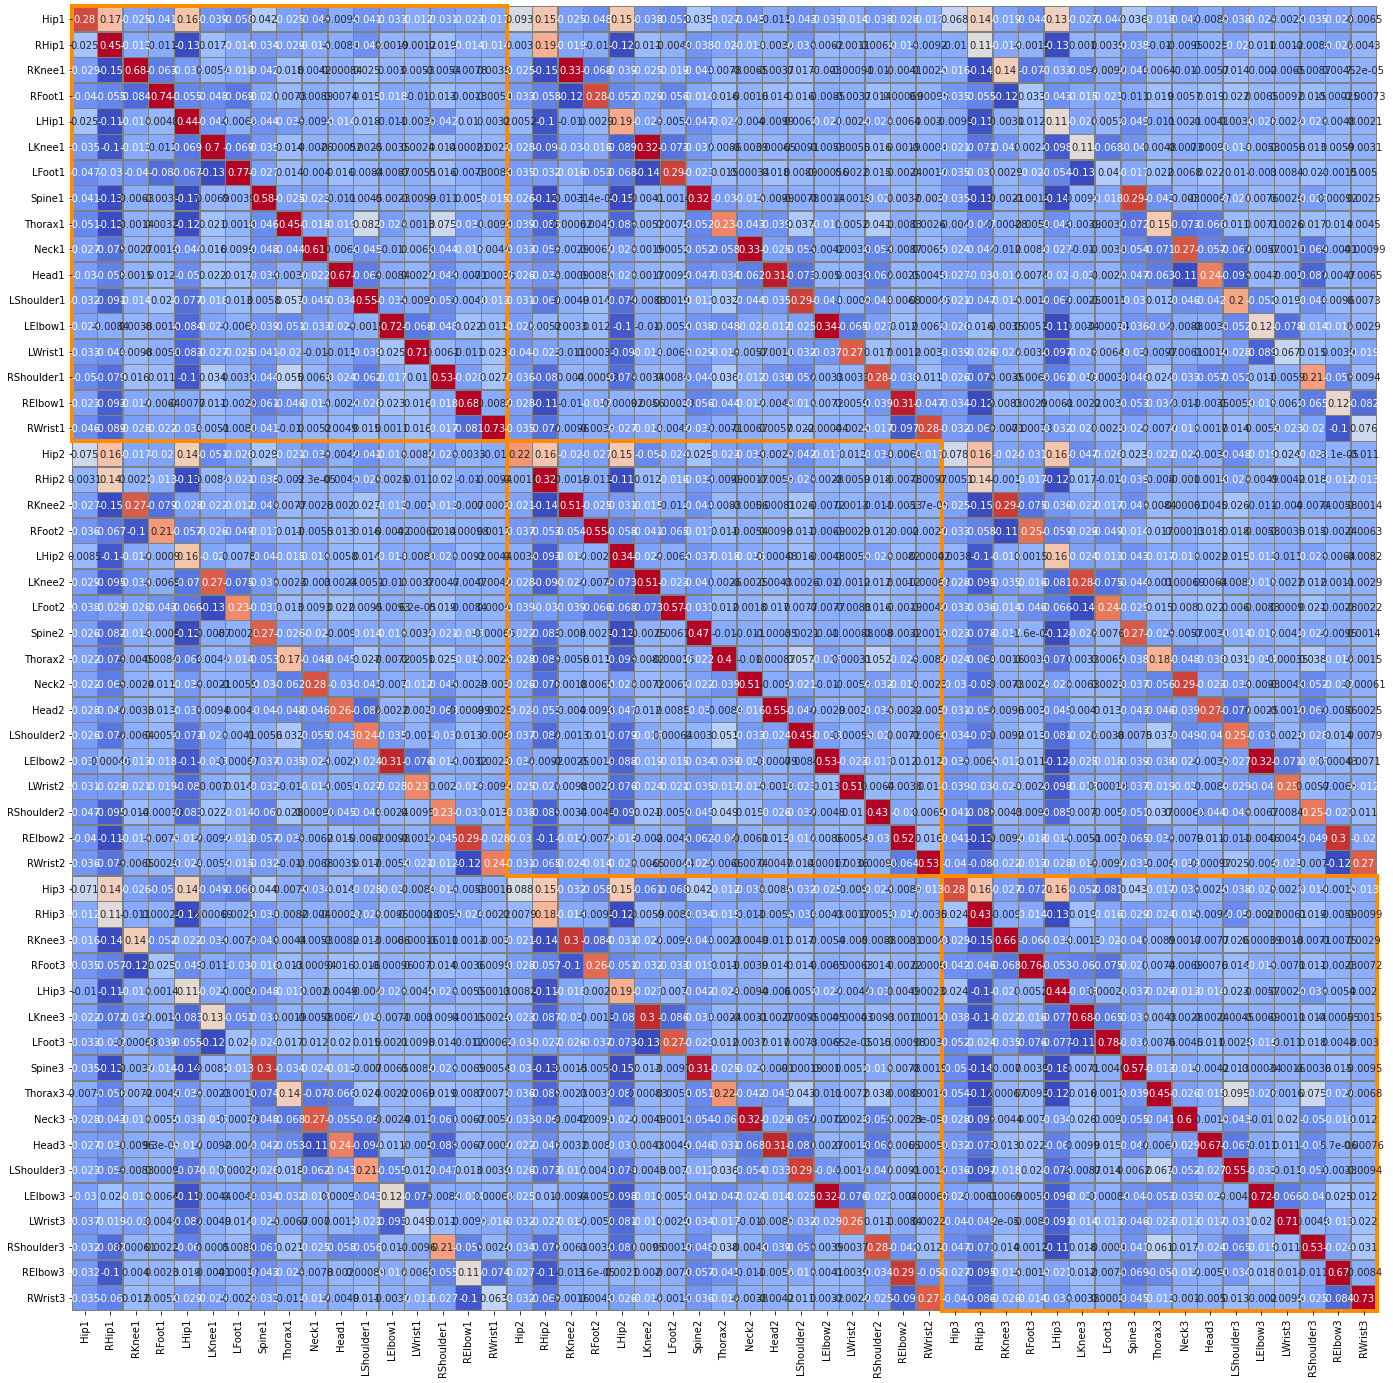

In [38]:
plot_adjacency_matrix(model.state_dict()['adj_v'][0].cpu(), node_names=get_node_names(3), annotate_values=True)

# Plotting Predicted 3D Poses

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# test_dataset = Human36M(data_dir="/media/HDD3/datasets/Human3.6M/pose_zip", train=False, ds_category=params.ds_category, actions='WalkDog')
test_dataset = PW3D(data_file="../data/pw3d_test.pkl", actions=['downtown_runForBus_01_0'])

downtown_runForBus_01_0


In [19]:
cam, pos2d, pos3d, angles_6d, edge_features = test_dataset.cam, test_dataset.pos2d, test_dataset.pos3d, [], []
val_generator = ChunkedGenerator_Seq2Seq(params.batch_size, cameras=cam, poses_2d=pos2d, poses_3d=pos3d,
                                                   chunk_length=31, pad=25, out_all=True, shuffle=False,
                                                   augment=False, reverse_aug=False,)

In [10]:
model.to(device)
None

In [11]:
from matplotlib.animation import PillowWriter, FFMpegWriter

In [28]:
gt_pos3d = np.empty([0, 17, 3])
pred_pose3d = np.empty([0, 17, 3])

i_batch = 0

with torch.no_grad():
    for cameras_val, batch_3d, batch_6d, batch_2d, batch_edge in val_generator.next_epoch():
        input_2d = torch.FloatTensor(batch_2d).to(device)
        target_pose_3d = torch.FloatTensor(batch_3d).to(device)
        cameras_val = torch.from_numpy(cameras_val.astype('float32')).to(device)

        middle_index = int((target_pose_3d.shape[1] - 1) / 2)
        pad = 15
        start_index = middle_index - pad
        end_index = middle_index + pad + 1
        B, T, J, D = target_pose_3d.shape

        predicted_pos3d = model(input_2d)
        predicted_pos3d_center = predicted_pos3d[:, start_index:end_index].reshape(B, (2 * pad + 1), J, D).cpu().data.numpy()
        print(predicted_pos3d_center.shape)

        # target_angle_6d = target_angle_6d[:, middle_index].view_as(predicted_angle_6d)
        target_pose_3d = target_pose_3d.view_as(predicted_pos3d)
        target_pose_3d_center = target_pose_3d[:, start_index:end_index].reshape(B, (2 * pad + 1), J, D).cpu().data.numpy()

        # target_pose_3d_center[:, :, :1] = 0
        # predicted_pos3d_center[:, :, :1] = 0
        target_pose_3d_center[:, :, 1:] += target_pose_3d_center[:, :, :1]
        predicted_pos3d_center[:, :, 1:] += predicted_pos3d_center[:, :, :1]

        if i_batch == 0:
            gt_pos3d = target_pose_3d_center.reshape(-1, J, D)
            pred_pose3d = predicted_pos3d_center.reshape(-1, J, D)
            # mpjpe_err = _mpjpe
        else:
            gt_pos3d = np.concatenate((gt_pos3d, target_pose_3d_center.reshape(-1, J, D)), axis=0)
            pred_pose3d = np.concatenate((pred_pose3d, predicted_pos3d_center.reshape(-1, J, D)), axis=0)
            print(pred_pose3d.shape)
            # mpjpe_err = np.concatenate((mpjpe_err,_mpjpe), axis=0)
            print(i_batch, gt_pos3d.shape, pred_pose3d.shape)

        i_batch += 1

(25, 31, 17, 3)


In [29]:
pred_pose3d.shape

(775, 17, 3)

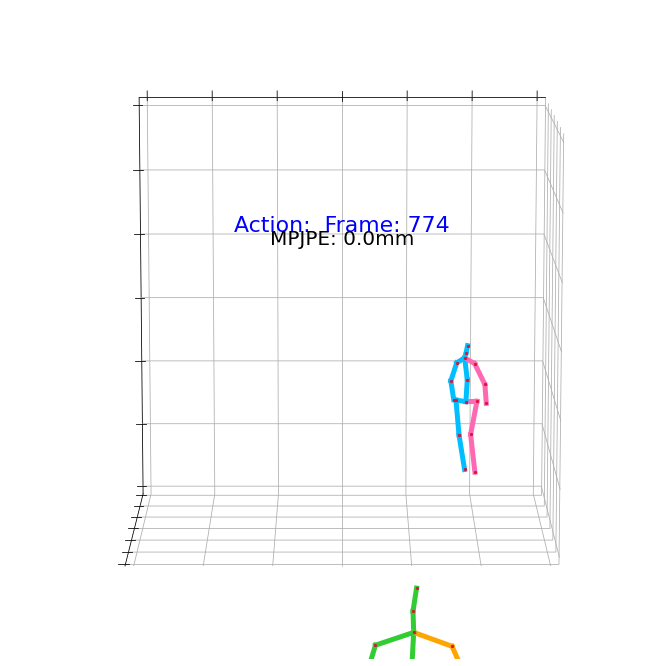

In [30]:
anim = plot_pose_animation(pred_pose3d, gt_pos3d=gt_pos3d, save_path="", num_frames=775)
anim.save("runforBus_pw3d.gif", dpi=50, writer=PillowWriter(fps=24))

In [45]:
# for transfer training

list(filter(lambda p: p[0] in ['post_traj.weight', 'post_traj.bias'], model.named_parameters()))

[('post_traj.weight',
  Parameter containing:
  tensor([[[[ 1.0513e-01,  1.6728e-01,  2.6267e-01,  1.4483e-01,  1.2638e-01]],
  
           [[ 6.3812e-02,  2.7582e-02,  9.2681e-02,  8.5009e-02,  4.5242e-02]],
  
           [[-1.5284e-01, -8.9147e-02, -1.5201e-01, -1.3722e-01, -1.4228e-01]],
  
           ...,
  
           [[ 5.1036e-01,  5.5369e-01,  9.0632e-01,  5.9386e-01,  5.5031e-01]],
  
           [[-2.2727e-03, -2.4344e-02, -4.4160e-02, -4.1691e-02, -2.0604e-02]],
  
           [[-2.1761e-02,  9.6432e-04, -1.7560e-02, -4.9823e-02, -2.6117e-02]]],
  
  
          [[[-2.1959e-02, -2.7242e-02, -9.2451e-03, -9.6705e-03, -3.6712e-03]],
  
           [[-1.0825e-01, -6.4891e-02, -1.1241e-01, -6.8731e-02, -9.6860e-02]],
  
           [[-3.0380e-03, -3.4406e-02, -3.4327e-02, -5.5522e-03, -3.9208e-03]],
  
           ...,
  
           [[-6.6104e-03, -5.7497e-02, -4.4241e-02, -3.4542e-02, -1.1356e-02]],
  
           [[ 7.2378e-02,  1.1097e-01,  1.2425e-01,  8.7611e-02,  9.8472e-02]],
  